In [1]:
!pip install transformers -q
!pip install sentencepiece -q

In [2]:
import datetime
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR
from torch.utils.data import Dataset, DataLoader, IterableDataset

from transformers import AutoModel, AutoTokenizer, AutoConfig

from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import compute_class_weight

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from IPython.display import display, HTML

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
def get_data_loader(dataset, batch_size=16, random_seed=42):
    g = torch.Generator()
    g.manual_seed(random_seed)
    return DataLoader(dataset, batch_size=batch_size, generator=g)

In [5]:
class FusionDataset(IterableDataset):
    def __init__(self, sequences, masks, features, labels, fsize=(40,9601)):
        self.sequences = sequences
        self.masks = masks
        self.labels = labels
        self.features = features
        self.fsize = fsize
    
    def __get__(self,index):
      if self.features[index].shape[1] < self.fsize[1]:
        self.features[index] = torch.hstack((self.features[index],
                                             torch.zeros(self.fsize[0],self.fsize[1]-self.features[index].shape[1])))
      return self.features[index].reshape((1,)+self.features[index].shape)

    def __len__(self):
        return len(self.labels)

    def __iter__(self):
        for index, _ in enumerate(self.labels):
            yield self.sequences[index], self.masks[index], self.__get__(index), self.labels[index]

    def __getitem__(self, index):
        return self.sequences[index], self.masks[index], self.__get__(index), self.labels[index]

    def get_data_loader(self, batch_size=16, random_seed=42):
        return get_data_loader(self, batch_size, random_seed)
    
    @staticmethod
    def _prepare_data_(data, sequences, masks, ids, target='RagamCode', audfeature='mel_spec', fsize=(40,9601)):
      lbls = torch.tensor([data[target].iloc[x] for x in ids])
      features = [data[audfeature].iloc[x] for x in ids] # aud feature is already tensor
      return FusionDataset(sequences[ids], masks[ids], features, lbls, fsize)

    @staticmethod
    def prepare_data(data, sequences, masks, train_ids, test_ids, target='RagamCode', audfeature='mel_spec', fsize=(40,9601)):
      return FusionDataset._prepare_data_(data, sequences, masks, train_ids, target, audfeature, fsize), FusionDataset._prepare_data_(data, sequences, masks, train_ids, target, audfeature, fsize)

In [6]:
class FusionModel(nn.Module):
  def __init__(self, transformer, n_labels=2, dropout=0.1):
    super().__init__()
    self.VEC_SIZE = 768
    self.transformer = transformer
    self.aud_layer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(1,1), padding='same'),            
            nn.ReLU(),
            nn.Conv2d(in_channels=1, out_channels=2, kernel_size=(2,2), padding='same'),            
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.AvgPool2d(kernel_size=4),
            nn.Flatten()
        )
    self.fusion = nn.Sequential(nn.Linear(48000+self.VEC_SIZE, 1000),
                                nn.ReLU(),
                                nn.Dropout(dropout),
                                nn.Linear(1000, n_labels))
  def forward(self, sequence, mask, aud):
    _, cls = self.transformer(sequence, attention_mask=mask, return_dict=False)
    aud = self.aud_layer(aud)
    x = torch.cat((aud, cls),1)
    return self.fusion(x)

In [7]:
def get_devices():
    if torch.cuda.is_available():
        gpu = torch.device("cuda")
    else:
        gpu = torch.device("cpu")
    cpu = torch.device("cpu")
    return gpu, cpu
gpu, cpu = get_devices()

In [8]:
def get_loss_function(balance_classes, labels, run_on, loss_fcn=nn.CrossEntropyLoss):
    if balance_classes:
        class_wts = compute_class_weight(class_weight='balanced',
                                         classes=np.unique(labels),
                                         y=labels
                                         )
        print(f'Class Weights : {class_wts}')
        # convert class weights to tensor
        weights = torch.tensor(class_wts, dtype=torch.float)
        weights = weights.to(run_on)
        # loss function
        loss_fcn = loss_fcn(weight=weights)
    else:
        loss_fcn = loss_fcn()
    return loss_fcn

In [9]:
def update_best_result(best_scores, valid_loss, train_labels, train_predictions, validation_labels,
                       validation_predictions, test_labels, test_predictions,
                       model=None, model_file_name=f'saved_weights_Fold_0.pt'):
    if valid_loss < best_scores['valid_loss']:
        best_scores['valid_loss'] = valid_loss
        best_scores['train_predictions'] = train_predictions
        best_scores['validation_predictions'] = validation_predictions
        best_scores['test_predictions'] = test_predictions
        best_scores['train_labels'] = train_labels
        best_scores['validation_labels'] = validation_labels
        best_scores['test_labels'] = test_labels
        if model:
            torch.save(model.state_dict(), model_file_name)
    return best_scores


def update_results_dict(results, train_labels, train_predictions, validation_labels, validation_predictions,
                        test_lbls, test_preds,
                        average='micro', pos_label=1):
    results['train_precision'].append(precision_score(train_labels, train_predictions, average=average))
    results['train_recall'].append(recall_score(train_labels, train_predictions, average=average))
    results['train_f1'].append(f1_score(train_labels, train_predictions, average=average))
    results['validation_precision'].append(precision_score(validation_labels, validation_predictions, average=average))
    results['validation_recall'].append(recall_score(validation_labels, validation_predictions, average=average))
    results['validation_f1'].append(
        f1_score(validation_labels, validation_predictions, average=average))
    results['test_precision'].append(precision_score(test_lbls, test_preds, average=average))
    results['test_recall'].append(recall_score(test_lbls, test_preds, average=average))
    results['test_f1'].append(
        f1_score(test_lbls, test_preds, average=average))
    results['train_labels'].append([train_labels])
    results['validation_labels'].append([validation_labels])
    results['test_labels'].append([test_lbls])
    results['train_predictions'].append([train_predictions])
    results['validation_predictions'].append([validation_predictions])
    results['test_predictions'].append([test_preds])
    return results

In [10]:
def run_model(model, dataset, loss_fcn, optimizer, is_training, run_on, clip_at=None, lstm_model=False, report_at=20):
    if is_training:
        model.train()
    else:
        model.eval()
    total_loss, total_accuracy, model_predictions, model_labels, aud_data = 0, 0, [], [], None
    for step, batch in enumerate(dataset):
        # push the batch to gpu
        batch = [r.to(run_on) for r in batch]
        sequences, masks, features, labels = batch
        if is_training:
            for o in optimizer:
                o.zero_grad()
            model.zero_grad()
            predictions = model(sequences, masks, features)
        else:
            with torch.no_grad(): 
              predictions = model(sequences, masks, features)
        # compute the loss between actual and predicted values
        loss = loss_fcn(predictions, labels)
        predictions = predictions.detach().cpu().numpy()
        total_loss = total_loss + loss.item()
        if is_training:
            loss.backward()  # backward pass to calculate the gradients
            if clip_at:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_at)
            # update parameters
            for o in optimizer:
                o.step()
        # append the model predictions
        model_predictions.append(predictions)
        model_labels.append(labels.detach().cpu().numpy())
        del batch
    # compute the training loss of the epoch
    avg_loss = total_loss / len(dataset)
    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    model_predictions = np.concatenate(model_predictions, axis=0)
    model_labels = np.concatenate(model_labels, axis=0)
    # returns the loss and predictions
    model_predictions = np.argmax(model_predictions, axis=1)
    return avg_loss, model_predictions, model_labels

In [11]:
def plot_results(results, model_name):
    fig = plt.figure(figsize=[20, 10])
    epochs = len(results[0]['train_precision'])
    x_label = f'{len(results)} Fold and {epochs} Epochs'

    def subplot_routine(key1, key2, title, loss=False, key3=None):
        plt.plot([x for k in results for x in results[k][key1]])
        plt.plot([x for k in results for x in results[k][key2]])
        if key3:
          plt.plot([x for k in results for x in results[k][key3]])
        plt.grid()
        plt.xlabel(x_label)
        if key3:
          plt.legend([f'{x} {title}' for x in ['Train', 'Val','Test']])
        else:
          plt.legend([f'{x} {title}' for x in ['Train', 'Val']])
        if not loss:
            plt.ylim([0, 1.1])
        else:
            b, t = plt.ylim()
            plt.ylim(np.floor(b), np.ceil(t))

    plt.subplot(2,1,1)
    subplot_routine('train_losses', 'validation_losses', 'Losses', True)
    plt.subplot(2,1,2)
    subplot_routine('train_f1', 'validation_f1', 'F1', key3='test_f1')
    plt.suptitle(f'Metrics for {model_name}')
    plt.tight_layout()
    plt.show()

In [12]:
def results_to_df(results):
    p = pd.DataFrame(results[0])
    for i in range(1, len(results)):
        p = pd.concat([p, pd.DataFrame(results[i])], axis=0)
    p.sort_values(by=['validation_f1', 'train_f1'], ascending=False, inplace=True)
    return p

In [13]:
def load_tx_model(rootpath):
  return AutoModel.from_pretrained(os.path.join(rootpath,'pytorch_model.bin'), local_files_only=True,
                                  config=AutoConfig.from_pretrained(os.path.join(rootpath,'config.json')))

In [14]:
def predict_test_data(model, chkpoint, test_data, gpu, feature='mel_spec', target='RagamCode'):
  txt = list(test_data.apply(lambda x: x.Lyric, axis=1))
  sequences, masks = get_seq_masks(chkpoint, txt)
  model = model.to(gpu)
  ds = FusionDataset(sequences, masks, test_data[feature].tolist(), test_data[target].tolist())
  model.eval()
  preds, truth = [], []
  for step, batch in enumerate(ds.get_data_loader(16)):
    batch = [r.to(gpu) for r in batch]
    sequences, masks, features, labels = batch
    with torch.no_grad():
      preds_batch = model(sequences, masks, features)
    preds_batch = preds_batch.detach().cpu().numpy()
    preds.append(preds_batch)
    truth.append(labels.detach().cpu().numpy())
    del batch
  preds = np.concatenate(preds, axis=0)
  truth = np.concatenate(truth, axis=0)
  preds = np.argmax(preds, axis=1)
  return preds, truth

In [15]:
def train_model(data, test_data, sequences, masks, rootpath, gpu, chkpoint, **kwargs):
    start_time = datetime.datetime.now()

    n_labels = kwargs['n_labels']
    title = kwargs['title']
    random_seed = kwargs['random_seed'] if 'random_seed' in kwargs else 42
    report = kwargs['report'] if 'report' in kwargs else 20
    lstm = kwargs['lstm'] if 'lstm' in kwargs else False
    lr = kwargs['lr'] if 'lr' in kwargs else 1e-4
    clip_at = kwargs['clip_at'] if 'clip_at' in kwargs else None
    k_folds = kwargs['k_folds'] if 'k_folds' in kwargs else 5
    balance_classes = kwargs['balance_classes'] if 'balance_classes' in kwargs else True
    dropout = kwargs['dropout'] if 'dropout' in kwargs else 0.1
    plot = kwargs['plot'] if 'plot' in kwargs else True
    epochs = kwargs['epochs'] if 'epochs' in kwargs else 5
    mdlargs = kwargs['mdlargs'] if 'mdlargs' in kwargs else {}
    feature = kwargs['feature'] if 'feature' in kwargs else ['mfcc_mean']
    target = kwargs['target'] if 'target' in kwargs else 'RagamCode'
    fsize = kwargs['fsize'] if 'fsize' in kwargs else (40,9601)
    loss_fcn = kwargs['loss_fcn'] if 'loss_fcn' in kwargs else None
    model_name = kwargs['model_name'] if 'model_name' in kwargs else 'model_state.pt'
    batch_size = kwargs['batch_size'] if 'batch_size' in kwargs else 32

    torch.manual_seed(random_seed)
    k_fold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=random_seed)
    results = {x: {} for x in range(k_folds)}
    ovl_best_scores = {'valid_loss': float('inf'),
                       'train_predictions': [],
                       'validation_predictions': [],
                       'train_labels': [],
                       'validation_labels': []
                       }
    for fold, (train_ids, validation_ids) in enumerate(k_fold.split(data[feature], data[target])):
        print(f'FOLD {fold + 1} \n Data Sizes (Train/Validation) : {len(train_ids)}/{len(validation_ids)}')
        fold_start = datetime.datetime.now()
        # empty lists to store training and validation loss of each epoch
        train_losses, valid_losses = [], []
        best_scores = {'valid_loss': float('inf'),
                       'train_predictions': [],
                       'validation_predictions': [],
                       'test_predictions' :[],
                       'train_labels': [],
                       'validation_labels': [],
                       'test_labels' : []
                       }
        # for each epoch
        results[fold] = {
            'train_f1': [],
            'validation_f1': [],
            'test_f1' : [],
            'train_precision': [],
            'validation_precision': [],
            'test_precision' :[],
            'train_recall': [],
            'validation_recall': [],
            'test_recall' :[],
            'train_labels': [],
            'validation_labels': [],
            'test_labels' : [],
            'train_predictions': [],
            'validation_predictions': [],
            'test_predictions':[]
        }
        train_data, validation_data = FusionDataset.prepare_data(data, sequences, masks, train_ids, validation_ids, target, feature, fsize)
        transformer = load_tx_model(rootpath)
        model = kwargs['model'](transformer, dropout=dropout, **mdlargs)
        model.to(gpu)
        if not loss_fcn:
            loss_fcn = get_loss_function(balance_classes, data[target].tolist(), gpu, nn.CrossEntropyLoss)
        # define the optimizer
        optimizer = [torch.optim.Adam(model.parameters(), lr=lr)]
        lr_schedulers = [ReduceLROnPlateau(optimizer[0], patience=3, factor=0.1, threshold=1e-9, mode='min'),
                         ExponentialLR(optimizer[0], gamma=0.9)]
        for epoch in range(epochs):
            e_start = datetime.datetime.now()
            # train model
            train_loss, train_predictions, train_labels = run_model(model,
                                                                    train_data.get_data_loader(batch_size=batch_size),
                                                                    loss_fcn, optimizer, run_on=gpu,
                                                                    is_training=True, clip_at=clip_at,
                                                                    lstm_model=lstm, report_at=report)
            # evaluate model
            valid_loss, validation_predictions, validation_labels = run_model(model,
                                                                              validation_data.get_data_loader(
                                                                              batch_size=batch_size),
                                                                              loss_fcn, optimizer, run_on=gpu,
                                                                              is_training=False, clip_at=clip_at,
                                                                              lstm_model=lstm, report_at=report)
            #for lr_scheduler in lr_schedulers:
                #lr_scheduler.step(valid_loss)
            torch.cuda.empty_cache()
            # save the best model
            test_preds, test_lbls = predict_test_data(model, chkpoint, test_data, gpu, feature=feature, target=target)
            best_scores = update_best_result(best_scores,
                                             valid_loss,
                                             train_labels, train_predictions,
                                             validation_labels, validation_predictions,
                                             test_lbls, test_preds)
            ovl_best_scores = update_best_result(ovl_best_scores,
                                                 valid_loss,
                                                 train_labels, train_predictions,
                                                 validation_labels, validation_predictions,
                                                 test_lbls, test_preds,
                                                 model=model,
                                                 model_file_name=f'{model_name}')
            # append training and validation loss
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
            results[fold] = update_results_dict(results[fold],
                                                train_labels, train_predictions,
                                                validation_labels, validation_predictions,
                                                test_lbls, test_preds)
            e_end = datetime.datetime.now()
            print(
                f'Epoch {epoch + 1}/{epochs} : Training Loss: {train_loss:.3f} / Validation Loss : {valid_loss:.3f} [Time : {(e_end - e_start).total_seconds()} seconds]')
        print('*** Confusion Matrix - Training ***')
        print(confusion_matrix(best_scores['train_labels'], best_scores['train_predictions']))
        print('*** Confusion Matrix - Validation ***')
        print(confusion_matrix(best_scores['validation_labels'], best_scores['validation_predictions']))
        results[fold]['train_losses'] = train_losses
        results[fold]['validation_losses'] = valid_losses
        print(f'Fold {fold + 1} : {(datetime.datetime.now() - fold_start).total_seconds()} seconds')
        # To ensure CUDA is not overloaded
        del model        
    end_time = datetime.datetime.now()
    print(f'Overall Time : {(end_time - start_time).total_seconds()} seconds')
    print('*** Confusion Matrix - Training ***')
    print(confusion_matrix(ovl_best_scores['train_labels'], ovl_best_scores['train_predictions']))
    print('*** Confusion Matrix - Validation ***')
    print(confusion_matrix(ovl_best_scores['validation_labels'], ovl_best_scores['validation_predictions']))

    if plot:
        plot_results(results, title)
    return results

In [16]:
data = pd.read_pickle('/content/drive/MyDrive/mp3_mels.pkl')
labels = torch.tensor(data['RagamCode'].tolist())
n_labels = len(data['RagamCode'].unique())
res_tbl_keys = ['train_f1','validation_f1','test_f1','train_precision','validation_precision','test_precision','train_recall','validation_recall','test_recall']

In [17]:
# Held out 10% Data
from sklearn.model_selection import train_test_split
Y1, Y2 = train_test_split(data['RagamCode'], test_size=0.1, random_state=42)

test_data = data.loc[Y2.index]
data = data.loc[Y1.index]

txt = list(data.apply(lambda x: x.Lyric, axis=1))

# Fusion with IndicBERT and MEL Spectrogram

In [18]:
def get_seq_masks(chkpoint, txt):
  tokenizer = AutoTokenizer.from_pretrained(chkpoint)
  all_tokens = tokenizer.batch_encode_plus(txt, max_length=96,
                                             padding='longest',
                                             truncation=True,
                                             return_token_type_ids=False)
  sequences = torch.tensor(all_tokens['input_ids'])
  attention_masks = torch.tensor(all_tokens['attention_mask'])
  return sequences, attention_masks

FOLD 1 
 Data Sizes (Train/Validation) : 820/205


Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Class Weights : [0.83333333 2.27777778 2.00980392 1.36666667 2.62820513 3.10606061
 1.13888889 1.36666667 0.94907407 1.79824561 1.42361111 3.41666667
 0.75925926 0.52564103 2.84722222 1.13888889 1.31410256 2.00980392
 2.44047619 2.44047619 0.66993464 0.63271605 0.38825758 1.70833333
 0.56010929 1.2202381  0.56010929 0.4495614  3.41666667 0.39272031]
Epoch 1/10 : Training Loss: 3.422 / Validation Loss : 3.398 [Time : 22.962517 seconds]
Epoch 2/10 : Training Loss: 3.399 / Validation Loss : 3.391 [Time : 23.001147 seconds]
Epoch 3/10 : Training Loss: 3.396 / Validation Loss : 3.387 [Time : 22.925845 seconds]
Epoch 4/10 : Training Loss: 3.390 / Validation Loss : 3.380 [Time : 22.881139 seconds]
Epoch 5/10 : Training Loss: 3.381 / Validation Loss : 3.371 [Time : 23.034083 seconds]
Epoch 6/10 : Training Loss: 3.394 / Validation Loss : 3.381 [Time : 22.241146 seconds]
Epoch 7/10 : Training Loss: 3.376 / Validation Loss : 3.361 [Time : 22.888311 seconds]
Epoch 8/10 : Training Loss: 3.360 / Val

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 13.806 / Validation Loss : 3.986 [Time : 22.182812 seconds]
Epoch 2/10 : Training Loss: 3.825 / Validation Loss : 1.717 [Time : 22.837563 seconds]
Epoch 3/10 : Training Loss: 1.719 / Validation Loss : 0.766 [Time : 22.886026 seconds]
Epoch 4/10 : Training Loss: 0.945 / Validation Loss : 0.485 [Time : 22.845787 seconds]
Epoch 5/10 : Training Loss: 0.593 / Validation Loss : 0.319 [Time : 22.951295 seconds]
Epoch 6/10 : Training Loss: 0.384 / Validation Loss : 0.236 [Time : 22.837067 seconds]
Epoch 7/10 : Training Loss: 0.292 / Validation Loss : 0.166 [Time : 22.989235 seconds]
Epoch 8/10 : Training Loss: 0.207 / Validation Loss : 0.125 [Time : 22.807806 seconds]
Epoch 9/10 : Training Loss: 0.164 / Validation Loss : 0.105 [Time : 22.837427 seconds]
Epoch 10/10 : Training Loss: 0.144 / Validation Loss : 0.089 [Time : 22.855404 seconds]
*** Confusion Matrix - Training ***
[[32  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 3.471 / Validation Loss : 3.411 [Time : 22.216138 seconds]
Epoch 2/10 : Training Loss: 3.422 / Validation Loss : 3.399 [Time : 22.165136 seconds]
Epoch 3/10 : Training Loss: 3.413 / Validation Loss : 3.397 [Time : 22.147565 seconds]
Epoch 4/10 : Training Loss: 3.410 / Validation Loss : 3.394 [Time : 22.136709 seconds]
Epoch 5/10 : Training Loss: 3.405 / Validation Loss : 3.392 [Time : 22.194929 seconds]
Epoch 6/10 : Training Loss: 3.400 / Validation Loss : 3.387 [Time : 22.167279 seconds]
Epoch 7/10 : Training Loss: 3.398 / Validation Loss : 3.381 [Time : 22.208981 seconds]
Epoch 8/10 : Training Loss: 3.391 / Validation Loss : 3.377 [Time : 22.200769 seconds]
Epoch 9/10 : Training Loss: 3.387 / Validation Loss : 3.370 [Time : 22.127818 seconds]
Epoch 10/10 : Training Loss: 3.376 / Validation Loss : 3.365 [Time : 22.245622 seconds]
*** Confusion Matrix - Training ***
[[ 0  0  1  0  0  0  4  1  0  4  0  0  4  1  0  0  1  5  0  0  0  1  1  1
   3  2  0  3  0  0

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 3.431 / Validation Loss : 3.211 [Time : 22.299774 seconds]
Epoch 2/10 : Training Loss: 3.152 / Validation Loss : 2.991 [Time : 22.270999 seconds]
Epoch 3/10 : Training Loss: 2.936 / Validation Loss : 2.768 [Time : 22.207215 seconds]
Epoch 4/10 : Training Loss: 2.718 / Validation Loss : 2.553 [Time : 22.182238 seconds]
Epoch 5/10 : Training Loss: 2.506 / Validation Loss : 2.350 [Time : 22.183862 seconds]
Epoch 6/10 : Training Loss: 2.308 / Validation Loss : 2.161 [Time : 22.100323 seconds]
Epoch 7/10 : Training Loss: 2.122 / Validation Loss : 1.984 [Time : 22.148909 seconds]
Epoch 8/10 : Training Loss: 1.957 / Validation Loss : 1.843 [Time : 22.121794 seconds]
Epoch 9/10 : Training Loss: 1.809 / Validation Loss : 1.686 [Time : 22.140934 seconds]
Epoch 10/10 : Training Loss: 1.662 / Validation Loss : 1.556 [Time : 22.09634 seconds]
*** Confusion Matrix - Training ***
[[23  0  0  1  0  0  0  0  0  0  5  0  0  0  0  0  0  0  1  0  2  0  0  1
   0  0  0  0  0  0]

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 27.818 / Validation Loss : 6.982 [Time : 22.159327 seconds]
Epoch 2/10 : Training Loss: 6.463 / Validation Loss : 2.564 [Time : 22.189097 seconds]
Epoch 3/10 : Training Loss: 2.809 / Validation Loss : 1.164 [Time : 22.144142 seconds]
Epoch 4/10 : Training Loss: 1.402 / Validation Loss : 0.562 [Time : 22.17376 seconds]
Epoch 5/10 : Training Loss: 0.683 / Validation Loss : 0.252 [Time : 22.160008 seconds]
Epoch 6/10 : Training Loss: 0.369 / Validation Loss : 0.172 [Time : 22.170441 seconds]
Epoch 7/10 : Training Loss: 0.333 / Validation Loss : 0.137 [Time : 22.137229 seconds]
Epoch 8/10 : Training Loss: 0.238 / Validation Loss : 0.098 [Time : 22.158999 seconds]
Epoch 9/10 : Training Loss: 0.135 / Validation Loss : 0.065 [Time : 22.811516 seconds]
Epoch 10/10 : Training Loss: 0.113 / Validation Loss : 0.046 [Time : 22.814358 seconds]
*** Confusion Matrix - Training ***
[[32  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0
   0  0  0  0  0  0

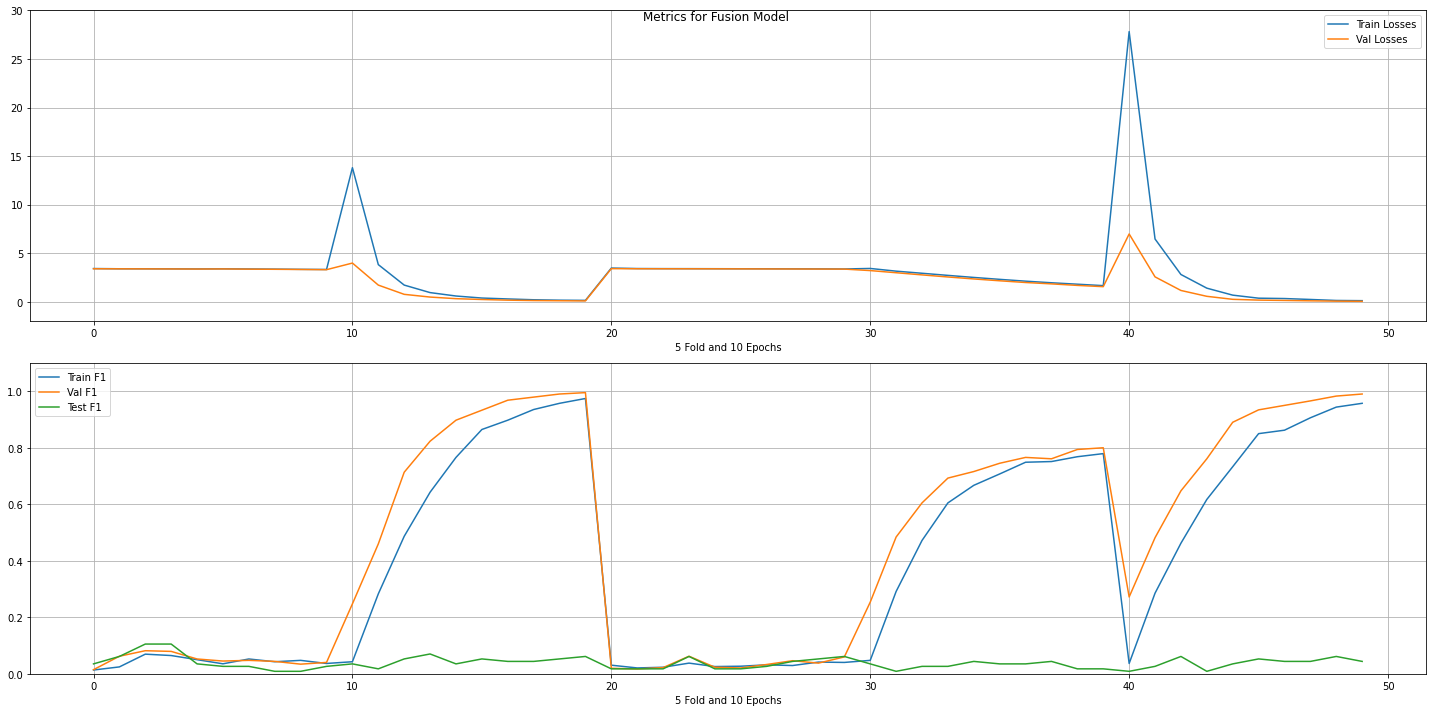

In [19]:
sequences, attention_masks = get_seq_masks('ai4bharat/indic-bert',txt)
indic_bert_result = train_model(data, test_data, sequences, attention_masks, '/content/drive/MyDrive/IndicBERT_FineTuned',
                                gpu, 'ai4bharat/indic-bert', n_labels=n_labels,feature='mel_spec', title='Fusion Model',
                                epochs=10, target='RagamCode', model=FusionModel, lr=1e-5, mdlargs={'n_labels':n_labels})

In [20]:
display(HTML(results_to_df(indic_bert_result)[res_tbl_keys].to_html().replace("\\n", "<br>")))

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
9,0.974390,0.995122,0.061404,0.974390,0.995122,0.061404,0.974390,0.995122,0.061404
8,0.957317,0.990244,0.052632,0.957317,0.990244,0.052632,0.957317,0.990244,0.052632
9,0.957317,0.990244,0.043860,0.957317,0.990244,0.043860,0.957317,0.990244,0.043860
8,0.943902,0.982927,0.061404,0.943902,0.982927,0.061404,0.943902,0.982927,0.061404
7,0.935366,0.979268,0.043860,0.935366,0.979268,0.043860,0.935366,0.979268,0.043860
6,0.897561,0.968293,0.043860,0.897561,0.968293,0.043860,0.897561,0.968293,0.043860
7,0.906098,0.965854,0.043860,0.906098,0.965854,0.043860,0.906098,0.965854,0.043860
6,0.862195,0.950000,0.043860,0.862195,0.950000,0.043860,0.862195,0.950000,0.043860
5,0.850000,0.934146,0.052632,0.850000,0.934146,0.052632,0.850000,0.934146,0.052632
5,0.864634,0.932927,0.052632,0.864634,0.932927,0.052632,0.864634,0.932927,0.052632


# MURIL Fusion

Downloading:   0%|          | 0.00/181 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.02M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/113 [00:00<?, ?B/s]

FOLD 1 
 Data Sizes (Train/Validation) : 820/205


Some weights of the model checkpoint at /content/drive/MyDrive/MURIL_FineTuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Class Weights : [0.83333333 2.27777778 2.00980392 1.36666667 2.62820513 3.10606061
 1.13888889 1.36666667 0.94907407 1.79824561 1.42361111 3.41666667
 0.75925926 0.52564103 2.84722222 1.13888889 1.31410256 2.00980392
 2.44047619 2.44047619 0.66993464 0.63271605 0.38825758 1.70833333
 0.56010929 1.2202381  0.56010929 0.4495614  3.41666667 0.39272031]
Epoch 1/10 : Training Loss: 3.418 / Validation Loss : 3.396 [Time : 25.825745 seconds]
Epoch 2/10 : Training Loss: 3.397 / Validation Loss : 3.388 [Time : 25.931459 seconds]
Epoch 3/10 : Training Loss: 3.391 / Validation Loss : 3.382 [Time : 25.882201 seconds]
Epoch 4/10 : Training Loss: 3.385 / Validation Loss : 3.378 [Time : 25.807703 seconds]
Epoch 5/10 : Training Loss: 3.382 / Validation Loss : 3.369 [Time : 26.007063 seconds]
Epoch 6/10 : Training Loss: 3.373 / Validation Loss : 3.363 [Time : 26.574534 seconds]
Epoch 7/10 : Training Loss: 3.367 / Validation Loss : 3.353 [Time : 26.895029 seconds]
Epoch 8/10 : Training Loss: 3.358 / Val

Some weights of the model checkpoint at /content/drive/MyDrive/MURIL_FineTuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 3.425 / Validation Loss : 3.401 [Time : 22.305609 seconds]
Epoch 2/10 : Training Loss: 3.403 / Validation Loss : 3.398 [Time : 22.003437 seconds]
Epoch 3/10 : Training Loss: 3.402 / Validation Loss : 3.397 [Time : 22.076886 seconds]
Epoch 4/10 : Training Loss: 3.402 / Validation Loss : 3.395 [Time : 22.035708 seconds]
Epoch 5/10 : Training Loss: 3.399 / Validation Loss : 3.394 [Time : 22.060303 seconds]
Epoch 6/10 : Training Loss: 3.398 / Validation Loss : 3.392 [Time : 22.059597 seconds]
Epoch 7/10 : Training Loss: 3.395 / Validation Loss : 3.390 [Time : 22.05555 seconds]
Epoch 8/10 : Training Loss: 3.393 / Validation Loss : 3.388 [Time : 22.053576 seconds]
Epoch 9/10 : Training Loss: 3.390 / Validation Loss : 3.385 [Time : 22.076263 seconds]
Epoch 10/10 : Training Loss: 3.388 / Validation Loss : 3.382 [Time : 22.047232 seconds]
*** Confusion Matrix - Training ***
[[ 0  2  0  1  1  0  0  0 20  0  1  0  0  0  0  0  0  2  0  0  1  0  5  0
   0  0  0  0  0  0]

Some weights of the model checkpoint at /content/drive/MyDrive/MURIL_FineTuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 3.952 / Validation Loss : 2.544 [Time : 26.326188 seconds]
Epoch 2/10 : Training Loss: 2.379 / Validation Loss : 1.864 [Time : 25.805932 seconds]
Epoch 3/10 : Training Loss: 1.736 / Validation Loss : 1.360 [Time : 25.85434 seconds]
Epoch 4/10 : Training Loss: 1.296 / Validation Loss : 1.017 [Time : 25.750157 seconds]
Epoch 5/10 : Training Loss: 0.990 / Validation Loss : 0.785 [Time : 25.805956 seconds]
Epoch 6/10 : Training Loss: 0.788 / Validation Loss : 0.612 [Time : 25.788999 seconds]
Epoch 7/10 : Training Loss: 0.616 / Validation Loss : 0.487 [Time : 26.33558 seconds]
Epoch 8/10 : Training Loss: 0.491 / Validation Loss : 0.385 [Time : 25.963568 seconds]
Epoch 9/10 : Training Loss: 0.396 / Validation Loss : 0.316 [Time : 26.613082 seconds]
Epoch 10/10 : Training Loss: 0.327 / Validation Loss : 0.261 [Time : 25.818644 seconds]
*** Confusion Matrix - Training ***
[[32  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]


Some weights of the model checkpoint at /content/drive/MyDrive/MURIL_FineTuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 3.449 / Validation Loss : 3.404 [Time : 22.57033 seconds]
Epoch 2/10 : Training Loss: 3.410 / Validation Loss : 3.400 [Time : 22.107688 seconds]
Epoch 3/10 : Training Loss: 3.409 / Validation Loss : 3.400 [Time : 21.999216 seconds]
Epoch 4/10 : Training Loss: 3.409 / Validation Loss : 3.399 [Time : 22.101609 seconds]
Epoch 5/10 : Training Loss: 3.406 / Validation Loss : 3.398 [Time : 22.088432 seconds]
Epoch 6/10 : Training Loss: 3.407 / Validation Loss : 3.396 [Time : 22.116445 seconds]
Epoch 7/10 : Training Loss: 3.402 / Validation Loss : 3.397 [Time : 22.097058 seconds]
Epoch 8/10 : Training Loss: 3.408 / Validation Loss : 3.398 [Time : 22.019229 seconds]
Epoch 9/10 : Training Loss: 3.404 / Validation Loss : 3.396 [Time : 22.040665 seconds]
Epoch 10/10 : Training Loss: 3.401 / Validation Loss : 3.395 [Time : 22.026854 seconds]
*** Confusion Matrix - Training ***
[[ 4  0  5  0  0  0  0  0  5  0  0  0  1  0  0  0  0  0  0  0  1  1  0  2
   0  0 13  1  0  0]

Some weights of the model checkpoint at /content/drive/MyDrive/MURIL_FineTuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 3.434 / Validation Loss : 3.392 [Time : 22.50836 seconds]
Epoch 2/10 : Training Loss: 3.397 / Validation Loss : 3.380 [Time : 22.054828 seconds]
Epoch 3/10 : Training Loss: 3.386 / Validation Loss : 3.369 [Time : 22.133591 seconds]
Epoch 4/10 : Training Loss: 3.376 / Validation Loss : 3.358 [Time : 22.037216 seconds]
Epoch 5/10 : Training Loss: 3.367 / Validation Loss : 3.346 [Time : 22.143947 seconds]
Epoch 6/10 : Training Loss: 3.352 / Validation Loss : 3.333 [Time : 22.059391 seconds]
Epoch 7/10 : Training Loss: 3.342 / Validation Loss : 3.324 [Time : 22.062506 seconds]
Epoch 8/10 : Training Loss: 3.329 / Validation Loss : 3.310 [Time : 22.017393 seconds]
Epoch 9/10 : Training Loss: 3.319 / Validation Loss : 3.297 [Time : 22.068393 seconds]
Epoch 10/10 : Training Loss: 3.305 / Validation Loss : 3.283 [Time : 22.045946 seconds]
*** Confusion Matrix - Training ***
[[ 0  0  3  0  0  0  0  0  2  1  2  0  0  0  0  5  5  2  0  0  0  1  0  3
   1  1  2  0  0  5]

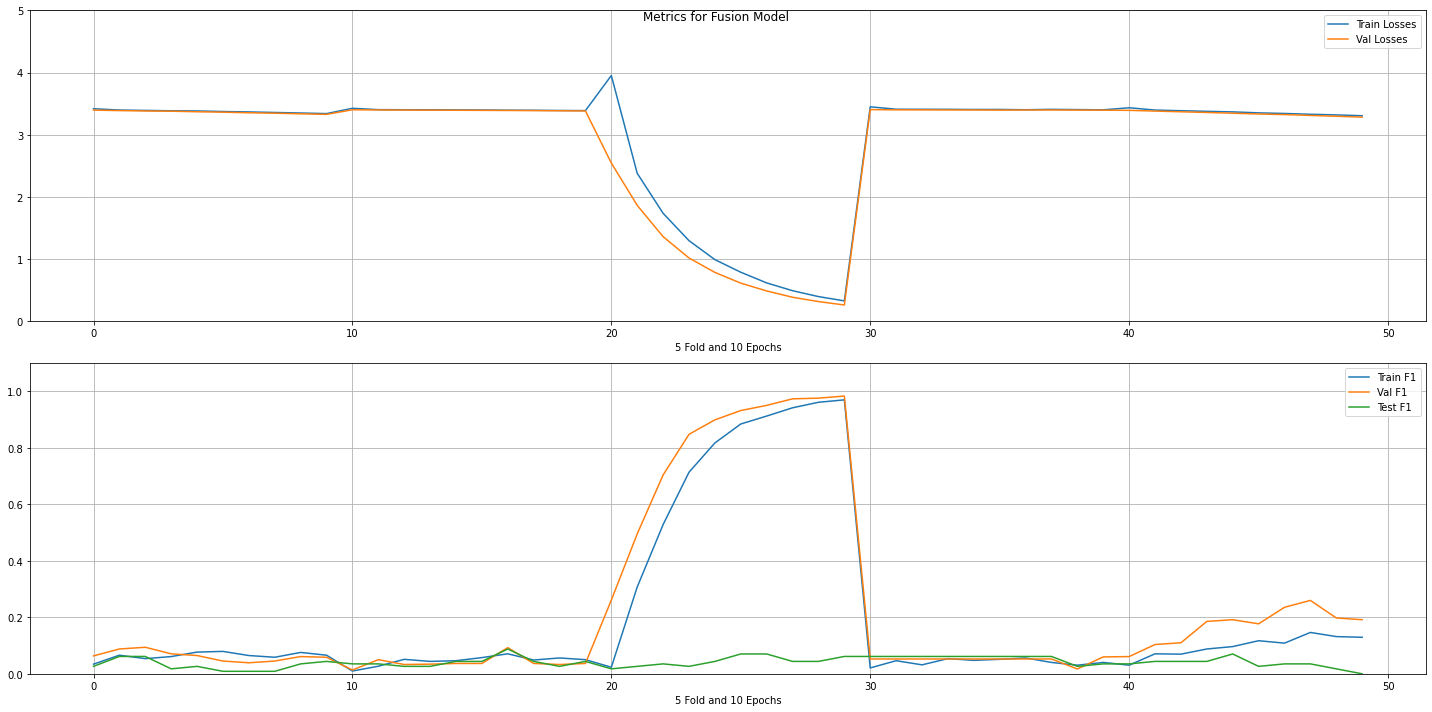

In [21]:
sequences, attention_masks = get_seq_masks('google/muril-base-cased',txt)
muril_result = train_model(data, test_data, sequences, attention_masks, '/content/drive/MyDrive/MURIL_FineTuned',
                                gpu, 'google/muril-base-cased', n_labels=n_labels,feature='mel_spec', title='Fusion Model',
                                epochs=10, target='RagamCode', model=FusionModel, lr=1e-5, mdlargs={'n_labels':n_labels})

In [22]:
display(HTML(results_to_df(muril_result)[res_tbl_keys].to_html().replace("\\n", "<br>")))

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
9,0.969512,0.982927,0.061404,0.969512,0.982927,0.061404,0.969512,0.982927,0.061404
8,0.960976,0.975610,0.043860,0.960976,0.975610,0.043860,0.960976,0.975610,0.043860
7,0.941463,0.973171,0.043860,0.941463,0.973171,0.043860,0.941463,0.973171,0.043860
6,0.912195,0.950000,0.070175,0.912195,0.950000,0.070175,0.912195,0.950000,0.070175
5,0.884146,0.931707,0.070175,0.884146,0.931707,0.070175,0.884146,0.931707,0.070175
4,0.817073,0.898780,0.043860,0.817073,0.898780,0.043860,0.817073,0.898780,0.043860
3,0.713415,0.847561,0.026316,0.713415,0.847561,0.026316,0.713415,0.847561,0.026316
2,0.528049,0.703659,0.035088,0.528049,0.703659,0.035088,0.528049,0.703659,0.035088
1,0.307317,0.495122,0.026316,0.307317,0.495122,0.026316,0.307317,0.495122,0.026316
0,0.023171,0.260976,0.017544,0.023171,0.260976,0.017544,0.023171,0.260976,0.017544


# XLM-R Fusion

FOLD 1 
 Data Sizes (Train/Validation) : 820/205


Some weights of the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin were not used when initializing XLMRobertaModel: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream

Class Weights : [0.83333333 2.27777778 2.00980392 1.36666667 2.62820513 3.10606061
 1.13888889 1.36666667 0.94907407 1.79824561 1.42361111 3.41666667
 0.75925926 0.52564103 2.84722222 1.13888889 1.31410256 2.00980392
 2.44047619 2.44047619 0.66993464 0.63271605 0.38825758 1.70833333
 0.56010929 1.2202381  0.56010929 0.4495614  3.41666667 0.39272031]
Epoch 1/10 : Training Loss: 3.701 / Validation Loss : 2.652 [Time : 26.919228 seconds]
Epoch 2/10 : Training Loss: 2.464 / Validation Loss : 1.936 [Time : 26.648977 seconds]
Epoch 3/10 : Training Loss: 1.825 / Validation Loss : 1.450 [Time : 27.477316 seconds]
Epoch 4/10 : Training Loss: 1.393 / Validation Loss : 1.110 [Time : 27.225618 seconds]
Epoch 5/10 : Training Loss: 1.073 / Validation Loss : 0.864 [Time : 27.783734 seconds]
Epoch 6/10 : Training Loss: 0.858 / Validation Loss : 0.683 [Time : 26.616084 seconds]
Epoch 7/10 : Training Loss: 0.679 / Validation Loss : 0.548 [Time : 26.537943 seconds]
Epoch 8/10 : Training Loss: 0.548 / Val

Some weights of the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin were not used when initializing XLMRobertaModel: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream

Epoch 1/10 : Training Loss: 3.631 / Validation Loss : 2.880 [Time : 22.225402 seconds]
Epoch 2/10 : Training Loss: 2.747 / Validation Loss : 2.264 [Time : 22.171205 seconds]
Epoch 3/10 : Training Loss: 2.182 / Validation Loss : 1.810 [Time : 21.916898 seconds]
Epoch 4/10 : Training Loss: 1.761 / Validation Loss : 1.457 [Time : 21.799535 seconds]
Epoch 5/10 : Training Loss: 1.435 / Validation Loss : 1.188 [Time : 21.865811 seconds]
Epoch 6/10 : Training Loss: 1.182 / Validation Loss : 0.978 [Time : 21.858354 seconds]
Epoch 7/10 : Training Loss: 0.976 / Validation Loss : 0.808 [Time : 21.821364 seconds]
Epoch 8/10 : Training Loss: 0.813 / Validation Loss : 0.675 [Time : 21.858626 seconds]
Epoch 9/10 : Training Loss: 0.682 / Validation Loss : 0.574 [Time : 21.794767 seconds]
Epoch 10/10 : Training Loss: 0.585 / Validation Loss : 0.489 [Time : 21.873292 seconds]
*** Confusion Matrix - Training ***
[[32  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0

Some weights of the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin were not used when initializing XLMRobertaModel: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream

Epoch 1/10 : Training Loss: 3.442 / Validation Loss : 3.402 [Time : 22.20833 seconds]
Epoch 2/10 : Training Loss: 3.408 / Validation Loss : 3.398 [Time : 22.221748 seconds]
Epoch 3/10 : Training Loss: 3.405 / Validation Loss : 3.396 [Time : 22.199315 seconds]
Epoch 4/10 : Training Loss: 3.401 / Validation Loss : 3.393 [Time : 21.978933 seconds]
Epoch 5/10 : Training Loss: 3.402 / Validation Loss : 3.390 [Time : 21.788306 seconds]
Epoch 6/10 : Training Loss: 3.400 / Validation Loss : 3.386 [Time : 21.756881 seconds]
Epoch 7/10 : Training Loss: 3.397 / Validation Loss : 3.382 [Time : 21.909458 seconds]
Epoch 8/10 : Training Loss: 3.390 / Validation Loss : 3.376 [Time : 21.777991 seconds]
Epoch 9/10 : Training Loss: 3.385 / Validation Loss : 3.368 [Time : 21.777766 seconds]
Epoch 10/10 : Training Loss: 3.376 / Validation Loss : 3.360 [Time : 21.777089 seconds]
*** Confusion Matrix - Training ***
[[ 0  3  0  0  0  0  0  0  0  0  0  0  1  0  0  1  0  4  0  0  0  0  0 20
   0  0  1  0  0  2]

Some weights of the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin were not used when initializing XLMRobertaModel: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream

Epoch 1/10 : Training Loss: 3.459 / Validation Loss : 3.390 [Time : 22.174157 seconds]
Epoch 2/10 : Training Loss: 3.397 / Validation Loss : 3.373 [Time : 21.941742 seconds]
Epoch 3/10 : Training Loss: 3.388 / Validation Loss : 3.361 [Time : 21.798841 seconds]
Epoch 4/10 : Training Loss: 3.376 / Validation Loss : 3.348 [Time : 21.815751 seconds]
Epoch 5/10 : Training Loss: 3.362 / Validation Loss : 3.333 [Time : 21.780772 seconds]
Epoch 6/10 : Training Loss: 3.353 / Validation Loss : 3.319 [Time : 21.753829 seconds]
Epoch 7/10 : Training Loss: 3.333 / Validation Loss : 3.315 [Time : 21.822751 seconds]
Epoch 8/10 : Training Loss: 3.334 / Validation Loss : 3.293 [Time : 21.773748 seconds]
Epoch 9/10 : Training Loss: 3.308 / Validation Loss : 3.276 [Time : 21.819157 seconds]
Epoch 10/10 : Training Loss: 3.291 / Validation Loss : 3.256 [Time : 21.779204 seconds]
*** Confusion Matrix - Training ***
[[10  0 13  1  1  0  0  0  0  0  0  0  0  0  0  0  1  0  2  0  2  0  2  0
   0  0  0  1  0  0

Some weights of the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin were not used when initializing XLMRobertaModel: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream

Epoch 1/10 : Training Loss: 4.030 / Validation Loss : 2.581 [Time : 22.18809 seconds]
Epoch 2/10 : Training Loss: 2.383 / Validation Loss : 1.850 [Time : 22.414268 seconds]
Epoch 3/10 : Training Loss: 1.749 / Validation Loss : 1.361 [Time : 21.89818 seconds]
Epoch 4/10 : Training Loss: 1.302 / Validation Loss : 1.044 [Time : 21.806633 seconds]
Epoch 5/10 : Training Loss: 1.015 / Validation Loss : 0.816 [Time : 21.79245 seconds]
Epoch 6/10 : Training Loss: 0.802 / Validation Loss : 0.650 [Time : 21.819421 seconds]
Epoch 7/10 : Training Loss: 0.648 / Validation Loss : 0.520 [Time : 21.796564 seconds]
Epoch 8/10 : Training Loss: 0.525 / Validation Loss : 0.427 [Time : 21.782991 seconds]
Epoch 9/10 : Training Loss: 0.433 / Validation Loss : 0.352 [Time : 21.90974 seconds]
Epoch 10/10 : Training Loss: 0.355 / Validation Loss : 0.294 [Time : 26.56237 seconds]
*** Confusion Matrix - Training ***
[[33  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 

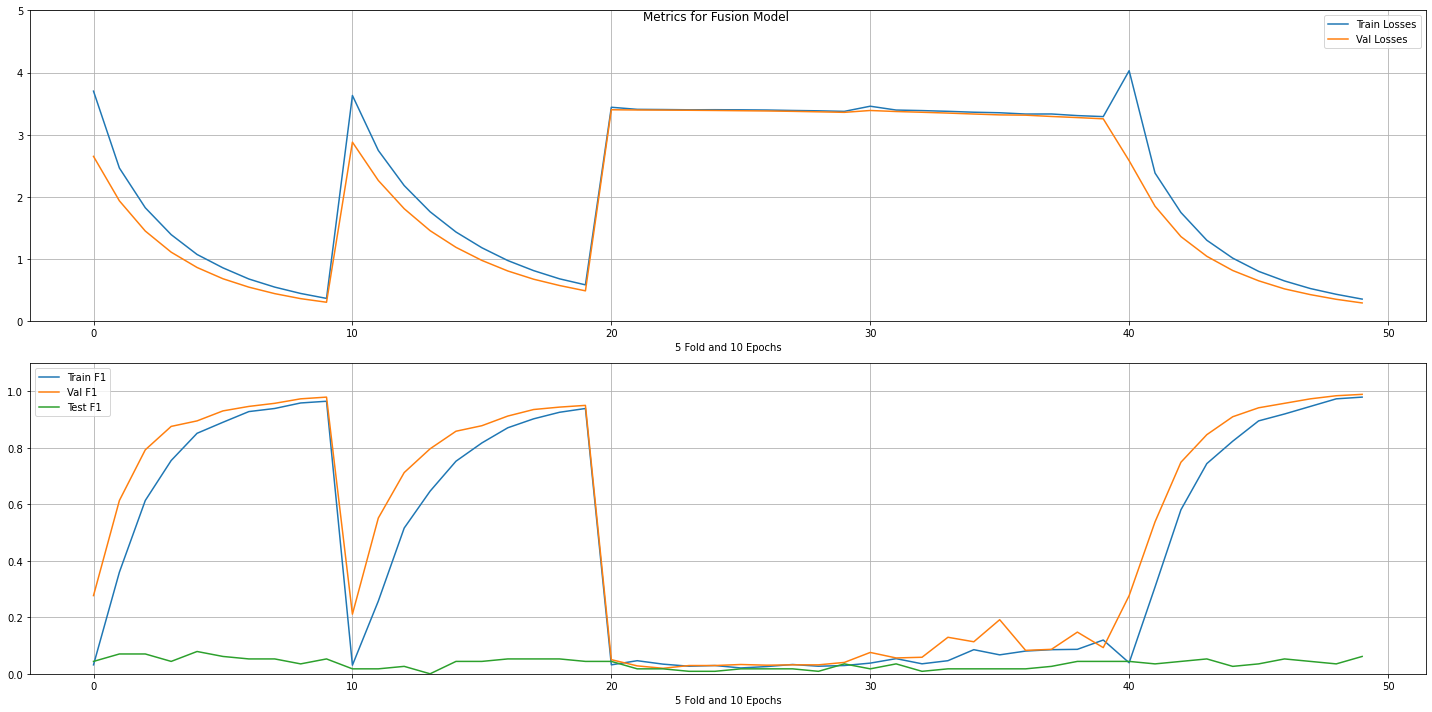

In [24]:
sequences, attention_masks = get_seq_masks('xlm-roberta-base',txt)
xlmr_result = train_model(data, test_data, sequences, attention_masks, '/content/drive/MyDrive/XLMR_Finetuned',
                                gpu, 'xlm-roberta-base', n_labels=n_labels,feature='mel_spec', title='Fusion Model',
                                epochs=10, target='RagamCode', model=FusionModel, lr=1e-5, mdlargs={'n_labels':n_labels})

In [25]:
display(HTML(results_to_df(xlmr_result)[res_tbl_keys].to_html().replace("\\n", "<br>")))

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
9,0.979268,0.989024,0.061404,0.979268,0.989024,0.061404,0.979268,0.989024,0.061404
8,0.973171,0.984146,0.035088,0.973171,0.984146,0.035088,0.973171,0.984146,0.035088
9,0.964634,0.979268,0.052632,0.964634,0.979268,0.052632,0.964634,0.979268,0.052632
8,0.958537,0.973171,0.035088,0.958537,0.973171,0.035088,0.958537,0.973171,0.035088
7,0.946341,0.973171,0.043860,0.946341,0.973171,0.043860,0.946341,0.973171,0.043860
7,0.939024,0.957317,0.052632,0.939024,0.957317,0.052632,0.939024,0.957317,0.052632
6,0.919512,0.957317,0.052632,0.919512,0.957317,0.052632,0.919512,0.957317,0.052632
9,0.939024,0.950000,0.043860,0.939024,0.950000,0.043860,0.939024,0.950000,0.043860
6,0.928049,0.946341,0.052632,0.928049,0.946341,0.052632,0.928049,0.946341,0.052632
8,0.925610,0.943902,0.052632,0.925610,0.943902,0.052632,0.925610,0.943902,0.052632


# MBERT Fusion

FOLD 1 
 Data Sizes (Train/Validation) : 820/205


Some weights of the model checkpoint at /content/drive/MyDrive/MBERT_Finetuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Class Weights : [0.83333333 2.27777778 2.00980392 1.36666667 2.62820513 3.10606061
 1.13888889 1.36666667 0.94907407 1.79824561 1.42361111 3.41666667
 0.75925926 0.52564103 2.84722222 1.13888889 1.31410256 2.00980392
 2.44047619 2.44047619 0.66993464 0.63271605 0.38825758 1.70833333
 0.56010929 1.2202381  0.56010929 0.4495614  3.41666667 0.39272031]
Epoch 1/10 : Training Loss: 3.413 / Validation Loss : 3.382 [Time : 25.156788 seconds]
Epoch 2/10 : Training Loss: 3.380 / Validation Loss : 3.365 [Time : 24.765693 seconds]
Epoch 3/10 : Training Loss: 3.366 / Validation Loss : 3.347 [Time : 23.719505 seconds]
Epoch 4/10 : Training Loss: 3.359 / Validation Loss : 3.337 [Time : 23.865294 seconds]
Epoch 5/10 : Training Loss: 3.334 / Validation Loss : 3.314 [Time : 23.397312 seconds]
Epoch 6/10 : Training Loss: 3.319 / Validation Loss : 3.300 [Time : 24.532649 seconds]
Epoch 7/10 : Training Loss: 3.302 / Validation Loss : 3.287 [Time : 23.388227 seconds]
Epoch 8/10 : Training Loss: 3.292 / Val

Some weights of the model checkpoint at /content/drive/MyDrive/MBERT_Finetuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 3.464 / Validation Loss : 3.009 [Time : 24.782532 seconds]
Epoch 2/10 : Training Loss: 2.894 / Validation Loss : 2.566 [Time : 23.836989 seconds]
Epoch 3/10 : Training Loss: 2.469 / Validation Loss : 2.176 [Time : 23.473957 seconds]
Epoch 4/10 : Training Loss: 2.102 / Validation Loss : 1.844 [Time : 23.472837 seconds]
Epoch 5/10 : Training Loss: 1.789 / Validation Loss : 1.570 [Time : 23.357898 seconds]
Epoch 6/10 : Training Loss: 1.527 / Validation Loss : 1.346 [Time : 24.833799 seconds]
Epoch 7/10 : Training Loss: 1.313 / Validation Loss : 1.163 [Time : 23.394687 seconds]
Epoch 8/10 : Training Loss: 1.146 / Validation Loss : 1.032 [Time : 23.405026 seconds]
Epoch 9/10 : Training Loss: 1.038 / Validation Loss : 0.958 [Time : 23.467741 seconds]
Epoch 10/10 : Training Loss: 0.937 / Validation Loss : 0.831 [Time : 23.899802 seconds]
*** Confusion Matrix - Training ***
[[31  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   2  0  0  0  0  0

Some weights of the model checkpoint at /content/drive/MyDrive/MBERT_Finetuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 8.437 / Validation Loss : 3.125 [Time : 20.77375 seconds]
Epoch 2/10 : Training Loss: 3.016 / Validation Loss : 1.693 [Time : 20.773824 seconds]
Epoch 3/10 : Training Loss: 1.562 / Validation Loss : 0.933 [Time : 20.849763 seconds]
Epoch 4/10 : Training Loss: 0.967 / Validation Loss : 0.597 [Time : 23.377664 seconds]
Epoch 5/10 : Training Loss: 0.645 / Validation Loss : 0.412 [Time : 23.391019 seconds]
Epoch 6/10 : Training Loss: 0.456 / Validation Loss : 0.314 [Time : 23.338124 seconds]
Epoch 7/10 : Training Loss: 0.356 / Validation Loss : 0.237 [Time : 23.346421 seconds]
Epoch 8/10 : Training Loss: 0.269 / Validation Loss : 0.188 [Time : 23.853617 seconds]
Epoch 9/10 : Training Loss: 0.225 / Validation Loss : 0.169 [Time : 23.935918 seconds]
Epoch 10/10 : Training Loss: 0.249 / Validation Loss : 0.149 [Time : 23.400799 seconds]
*** Confusion Matrix - Training ***
[[31  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]

Some weights of the model checkpoint at /content/drive/MyDrive/MBERT_Finetuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 6.119 / Validation Loss : 2.748 [Time : 20.739225 seconds]
Epoch 2/10 : Training Loss: 2.416 / Validation Loss : 1.532 [Time : 20.770493 seconds]
Epoch 3/10 : Training Loss: 1.462 / Validation Loss : 0.940 [Time : 20.752361 seconds]
Epoch 4/10 : Training Loss: 0.946 / Validation Loss : 0.668 [Time : 20.762985 seconds]
Epoch 5/10 : Training Loss: 0.685 / Validation Loss : 0.494 [Time : 20.740132 seconds]
Epoch 6/10 : Training Loss: 0.503 / Validation Loss : 0.375 [Time : 20.760844 seconds]
Epoch 7/10 : Training Loss: 0.402 / Validation Loss : 0.293 [Time : 20.804613 seconds]
Epoch 8/10 : Training Loss: 0.326 / Validation Loss : 0.238 [Time : 20.770155 seconds]
Epoch 9/10 : Training Loss: 0.277 / Validation Loss : 0.207 [Time : 20.772667 seconds]
Epoch 10/10 : Training Loss: 0.231 / Validation Loss : 0.161 [Time : 21.077081 seconds]
*** Confusion Matrix - Training ***
[[32  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  1  0  0  0

Some weights of the model checkpoint at /content/drive/MyDrive/MBERT_Finetuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 9.718 / Validation Loss : 3.019 [Time : 21.285878 seconds]
Epoch 2/10 : Training Loss: 2.499 / Validation Loss : 1.320 [Time : 21.262163 seconds]
Epoch 3/10 : Training Loss: 1.362 / Validation Loss : 0.735 [Time : 21.279665 seconds]
Epoch 4/10 : Training Loss: 0.743 / Validation Loss : 0.447 [Time : 20.862441 seconds]
Epoch 5/10 : Training Loss: 0.497 / Validation Loss : 0.310 [Time : 20.82415 seconds]
Epoch 6/10 : Training Loss: 0.354 / Validation Loss : 0.256 [Time : 20.804523 seconds]
Epoch 7/10 : Training Loss: 0.282 / Validation Loss : 0.182 [Time : 20.829017 seconds]
Epoch 8/10 : Training Loss: 0.210 / Validation Loss : 0.142 [Time : 23.860047 seconds]
Epoch 9/10 : Training Loss: 0.164 / Validation Loss : 0.110 [Time : 23.313203 seconds]
Epoch 10/10 : Training Loss: 0.126 / Validation Loss : 0.090 [Time : 23.381382 seconds]
*** Confusion Matrix - Training ***
[[33  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]

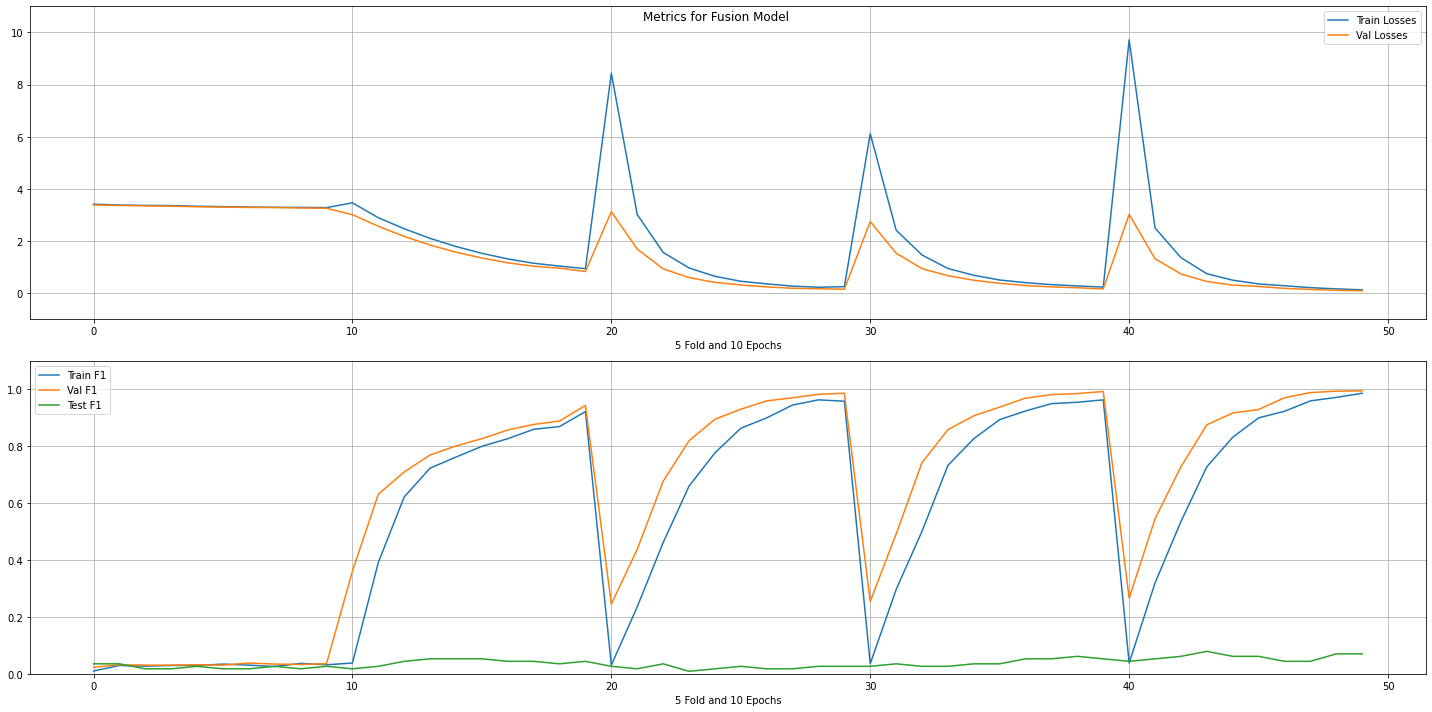

In [28]:
sequences, attention_masks = get_seq_masks('bert-base-multilingual-cased',txt)
mbert_result = train_model(data, test_data, sequences, attention_masks, '/content/drive/MyDrive/MBERT_Finetuned',
                                gpu, 'bert-base-multilingual-cased', n_labels=n_labels,feature='mel_spec', title='Fusion Model',
                                epochs=10, target='RagamCode', model=FusionModel, lr=1e-5, mdlargs={'n_labels':n_labels})

In [29]:
display(HTML(results_to_df(mbert_result)[res_tbl_keys].to_html().replace("\\n", "<br>")))

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
9,0.986585,0.995122,0.070175,0.986585,0.995122,0.070175,0.986585,0.995122,0.070175
8,0.971951,0.993902,0.070175,0.971951,0.993902,0.070175,0.971951,0.993902,0.070175
9,0.963415,0.992683,0.052632,0.963415,0.992683,0.052632,0.963415,0.992683,0.052632
7,0.959756,0.989024,0.043860,0.959756,0.989024,0.043860,0.959756,0.989024,0.043860
9,0.958537,0.986585,0.026316,0.958537,0.986585,0.026316,0.958537,0.986585,0.026316
8,0.954878,0.985366,0.061404,0.954878,0.985366,0.061404,0.954878,0.985366,0.061404
8,0.963415,0.982927,0.026316,0.963415,0.982927,0.026316,0.963415,0.982927,0.026316
7,0.950000,0.981707,0.052632,0.950000,0.981707,0.052632,0.950000,0.981707,0.052632
7,0.945122,0.970732,0.017544,0.945122,0.970732,0.017544,0.945122,0.970732,0.017544
6,0.923171,0.970732,0.043860,0.923171,0.970732,0.043860,0.923171,0.970732,0.043860
